假设 batch_size 为 2，两个输入的序列长度分别为 1 和 10，模型的输入尺寸为 [2, 10, hidden_dim]，理论上讲，BatchNorm 计算均值和方差应该针对这 11 个向量进行，但是由于第一个输入有 9 个位置都是 padding，所以直接对 [2, 10, hidden_dim] 的模型输入做 BatchNorm 实际将这 9 个 padding 也纳入到了均值和方差的计算过程中，显然不对。

LayerNorm，在做归一化时直接不考虑序列这一维度，只在每一个位置的特征内部自己做归一化，即**针对每一位置的维度为hidden_dim的特征单独计算均值和方差**，这样的话就可以避免序列长度不同对于归一化的影响。

**BatchNorm**:
$$
\begin{aligned}
\mu_B &= \frac{1}{m} \sum_{i=1}^{m} x_i \\
\sigma_B^2 &= \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2 \\
\hat{x}_i &= \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \\
y_i &= \gamma \hat{x}_i + \beta
\end{aligned}
$$

**LayerNorm**:
$$
\begin{aligned}
\mu_L &= \frac{1}{H} \sum_{i=1}^{H} x_i \\
\sigma_L^2 &= \frac{1}{H} \sum_{i=1}^{H} (x_i - \mu_L)^2 \\
\hat{x}_i &= \frac{x_i - \mu_L}{\sqrt{\sigma_L^2 + \epsilon}} \\
y_i &= \gamma \hat{x}_i + \beta
\end{aligned}
$$

**RMSNorm**:


$$
\begin{aligned}\mathbf{v} & =\left[v_{1}, v_{2}, \cdots, v_{d}\right] \\\operatorname{RMS}(\mathbf{v}) & =\sqrt{\frac{1}{d} \sum_{i=1}^{d} v_{i}^{2}} \\\forall i \in\{1, \cdots, d\}, o_{i} & =\frac{v_{i}}{\operatorname{RMS}(\mathbf{v})} g_{i}\end{aligned}
$$

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

B, T, C = 2, 10, 256
x = torch.randn(B, T, C)

# Calculate statistics before BatchNorm
x_for_bn = x.transpose(1, 2)  # Shape: [B, C, T]
mean_before = x_for_bn.mean(dim=(0, 2))  # Mean across batch and sequence dimensions
var_before = x_for_bn.var(dim=(0, 2))    # Variance across batch and sequence dimensions

# Apply BatchNorm
batch_norm = nn.BatchNorm1d(C)
x_bn = batch_norm(x_for_bn)
x_bn_transposed = x_bn.transpose(1, 2)

# Calculate statistics after BatchNorm
mean_after = x_bn.mean(dim=(0, 2))
var_after = x_bn.var(dim=(0, 2))

var_before.shape

torch.Size([256])

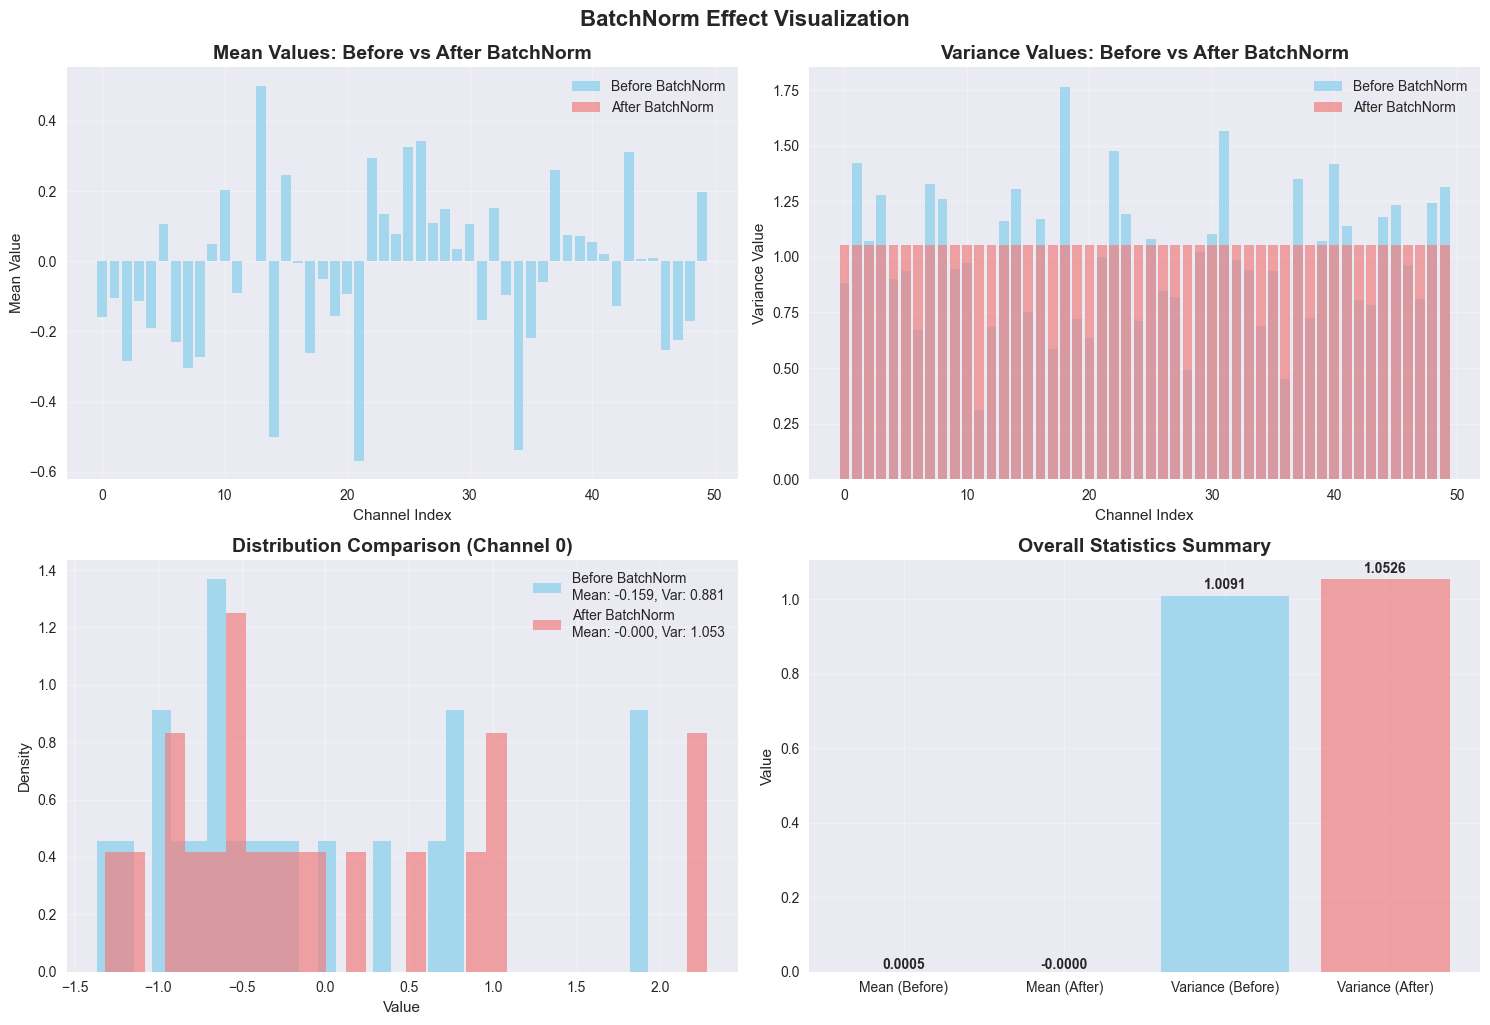

Output shape: torch.Size([2, 10, 256])
Mean before BatchNorm: 0.000497
Mean after BatchNorm: -0.000000
Variance before BatchNorm: 1.009091
Variance after BatchNorm: 1.052619


In [ ]:
# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Mean before and after
channels_subset = range(0, min(50, C))  # Show first 50 channels for clarity
ax1.bar(channels_subset, mean_before[channels_subset].detach().numpy(), alpha=0.7, label='Before BatchNorm', color='skyblue')
ax1.bar(channels_subset, mean_after[channels_subset].detach().numpy(), alpha=0.7, label='After BatchNorm', color='lightcoral')
ax1.set_title('Mean Values: Before vs After BatchNorm', fontsize=14, fontweight='bold')
ax1.set_xlabel('Channel Index')
ax1.set_ylabel('Mean Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Variance before and after
ax2.bar(channels_subset, var_before[channels_subset].detach().numpy(), alpha=0.7, label='Before BatchNorm', color='skyblue')
ax2.bar(channels_subset, var_after[channels_subset].detach().numpy(), alpha=0.7, label='After BatchNorm', color='lightcoral')
ax2.set_title('Variance Values: Before vs After BatchNorm', fontsize=14, fontweight='bold')
ax2.set_xlabel('Channel Index')
ax2.set_ylabel('Variance Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution comparison for a single channel
channel_idx = 0
x_single_channel_before = x_for_bn[:, channel_idx, :].flatten().detach().numpy()
x_single_channel_after = x_bn[:, channel_idx, :].flatten().detach().numpy()

ax3.hist(x_single_channel_before, bins=30, alpha=0.7, label=f'Before BatchNorm\nMean: {mean_before[channel_idx]:.3f}, Var: {var_before[channel_idx]:.3f}', color='skyblue', density=True)
ax3.hist(x_single_channel_after, bins=30, alpha=0.7, label=f'After BatchNorm\nMean: {mean_after[channel_idx]:.3f}, Var: {var_after[channel_idx]:.3f}', color='lightcoral', density=True)
ax3.set_title(f'Distribution Comparison (Channel {channel_idx})', fontsize=14, fontweight='bold')
ax3.set_xlabel('Value')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Statistics summary
stats_labels = ['Mean (Before)', 'Mean (After)', 'Variance (Before)', 'Variance (After)']
stats_values = [
    mean_before.mean().item(),
    mean_after.mean().item(),
    var_before.mean().item(),
    var_after.mean().item()
]
colors = ['skyblue', 'lightcoral', 'skyblue', 'lightcoral']

bars = ax4.bar(stats_labels, stats_values, color=colors, alpha=0.7)
ax4.set_title('Overall Statistics Summary', fontsize=14, fontweight='bold')
ax4.set_ylabel('Value')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, stats_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('BatchNorm Effect Visualization', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"Output shape: {x_bn_transposed.shape}")
print(f"Mean before BatchNorm: {mean_before.mean().item():.6f}")
print(f"Mean after BatchNorm: {mean_after.mean().item():.6f}")
print(f"Variance before BatchNorm: {var_before.mean().item():.6f}")
print(f"Variance after BatchNorm: {var_after.mean().item():.6f}")

In [2]:
import torch
import torch.nn as nn

batch_size = 2
seq_len = 10
hidden_dim = 512

# Simulate input in Transformer Block
x = torch.randn(batch_size, seq_len, hidden_dim)
print(f"Input shape: {x.shape}")

# 1. BatchNorm (usually not used in Transformer, shown for demonstration only)
# BatchNorm normalizes over the batch dimension
batch_norm = nn.BatchNorm1d(hidden_dim)
# Need to adjust dimensions: (batch_size, seq_len, hidden_dim) -> (batch_size, hidden_dim, seq_len)
x_bn = x.transpose(1, 2)
x_bn_out = batch_norm(x_bn).transpose(1, 2)
print(f"BatchNorm output shape: {x_bn_out.shape}")

# 2. LayerNorm (most commonly used in Transformer)
# LayerNorm normalizes over the last dimension
layer_norm = nn.LayerNorm(hidden_dim)
x_ln_out = layer_norm(x)
print(f"LayerNorm output shape: {x_ln_out.shape}")

# 3. RMSNorm (used in modern models like LLaMA)
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # Calculate RMS
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        # Normalize and apply learnable parameters
        return x / rms * self.weight

rms_norm = RMSNorm(hidden_dim)
x_rms_out = rms_norm(x)
print(f"RMSNorm output shape: {x_rms_out.shape}")

# Typical usage in Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        # Can choose different normalization methods
        self.norm1 = nn.LayerNorm(hidden_dim)  # or RMSNorm(hidden_dim)
        self.norm2 = nn.RMSNorm(hidden_dim)  # or RMSNorm(hidden_dim)
    
    def forward(self, x):
        # Pre-norm structure (commonly used in modern Transformer)
        attn_out, _ = self.attention(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out
        
        ffn_out = self.ffn(self.norm2(x))
        x = x + ffn_out
        
        return x

# Test Transformer Block
block = TransformerBlock(hidden_dim, num_heads=8)
output = block(x)
print(f"Transformer Block output shape: {output.shape}")

Input shape: torch.Size([2, 10, 512])
BatchNorm output shape: torch.Size([2, 10, 512])
LayerNorm output shape: torch.Size([2, 10, 512])
RMSNorm output shape: torch.Size([2, 10, 512])
Transformer Block output shape: torch.Size([2, 10, 512])
